# User Journey Mapping

Exploring customer behavior patterns and journey flows

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

### 1. DATA LOADING AND PREPARATION

In [4]:
df = pd.read_csv('../data/raw/saas_sales.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Basic data info
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Overview:
Shape: (9994, 19)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Date Key', 'Contact Name', 'Country', 'City', 'Region', 'Subregion', 'Customer', 'Customer ID', 'Industry', 'Segment', 'Product', 'License', 'Sales', 'Quantity', 'Discount', 'Profit']

First few rows:
   Row ID          Order ID  Order Date  Date Key    Contact Name  \
0       1  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
1       2  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
2       3  AMER-2022-138688   6/13/2022  20220613  Deirdre Bailey   
3       4  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   
4       5  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   

         Country           City Region Subregion           Customer  \
0        Ireland         Dublin   EMEA      UKIR            Chevron   
1        Ireland         Dublin   EMEA      UKIR            Chevron   
2  United States  New York City   AMER     NAMER        Phillips 66   
3        Germany 

### 2. DATA PREPROCESSING FOR JOURNEY ANALYSIS

In [5]:
# Convert date columns to datetime (adjust column names based on actual dataset)
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create journey-specific features
def create_journey_features(df):
    """Create features for user journey analysis"""
    
    # Assuming we have customer_id and date columns
    customer_col = [col for col in df.columns if 'customer' in col.lower() or 'user' in col.lower()][0]
    date_col = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()][0]
    
    # Sort by customer and date
    df = df.sort_values([customer_col, date_col])
    
    # Create journey features
    df['customer_journey_day'] = df.groupby(customer_col)[date_col].transform(
        lambda x: (x - x.min()).dt.days
    )
    
    df['interaction_sequence'] = df.groupby(customer_col).cumcount() + 1
    
    # Time between interactions
    df['time_since_last_interaction'] = df.groupby(customer_col)[date_col].diff().dt.days
    
    # Customer lifecycle stage
    df['customer_age_days'] = (df[date_col] - df.groupby(customer_col)[date_col].transform('min')).dt.days
    
    def lifecycle_stage(days):
        if days <= 30:
            return 'New'
        elif days <= 90:
            return 'Growing'
        elif days <= 180:
            return 'Mature'
        else:
            return 'Loyal'
    
    df['lifecycle_stage'] = df['customer_age_days'].apply(lifecycle_stage)
    
    return df

# Apply journey feature creation
df = create_journey_features(df)

print("\nJourney Features Created:")
print(df[['customer_journey_day', 'interaction_sequence', 'lifecycle_stage']].head(10))


Journey Features Created:
      customer_journey_day  interaction_sequence lifecycle_stage
8299                     0                     1             New
1890                     3                     2             New
1891                     3                     3             New
1560                    24                     4             New
7019                   165                     5          Mature
7020                   165                     6          Mature
7021                   165                     7          Mature
7022                   165                     8          Mature
7023                   165                     9          Mature
7024                   165                    10          Mature


### 3. CUSTOMER JOURNEY OVERVIEW


Customer Journey Summary:
                     total_interactions  journey_length_days  \
Customer                                                       
AT&T                                151                 1381   
Abbott Laboratories                  67                 1343   
Aetna                               153                 1349   
Airbus                              123                 1423   
Allianz                             192                 1383   
Allstate                            105                 1410   
Alphabet                             44                 1309   
Amazon                              134                 1434   
American Express                    137                 1393   
AmerisourceBergen                   149                 1403   

                    first_interaction last_interaction current_stage  
Customer                                                              
AT&T                       2020-03-11       2023-12-22        

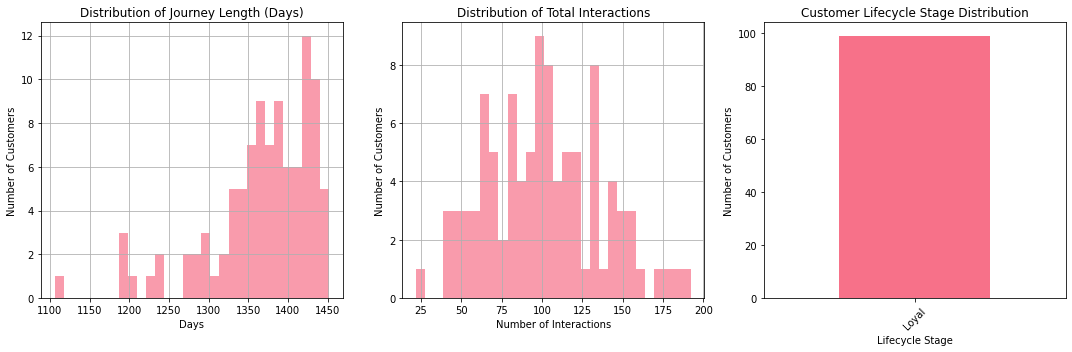

In [6]:
# Get customer and date column names
customer_col = [col for col in df.columns if 'customer' in col.lower() or 'user' in col.lower()][0]
date_col = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()][0]

# Customer journey summary
journey_summary = df.groupby(customer_col).agg({
    'interaction_sequence': 'max',
    'customer_journey_day': 'max',
    date_col: ['min', 'max'],
    'lifecycle_stage': 'last'
}).round(2)

journey_summary.columns = ['total_interactions', 'journey_length_days', 'first_interaction', 
                          'last_interaction', 'current_stage']

print("\nCustomer Journey Summary:")
print(journey_summary.head(10))

# Journey length distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
journey_summary['journey_length_days'].hist(bins=30, alpha=0.7)
plt.title('Distribution of Journey Length (Days)')
plt.xlabel('Days')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 2)
journey_summary['total_interactions'].hist(bins=30, alpha=0.7)
plt.title('Distribution of Total Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 3)
journey_summary['current_stage'].value_counts().plot(kind='bar')
plt.title('Customer Lifecycle Stage Distribution')
plt.xlabel('Lifecycle Stage')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 4. INTERACTION PATTERNS ANALYSIS

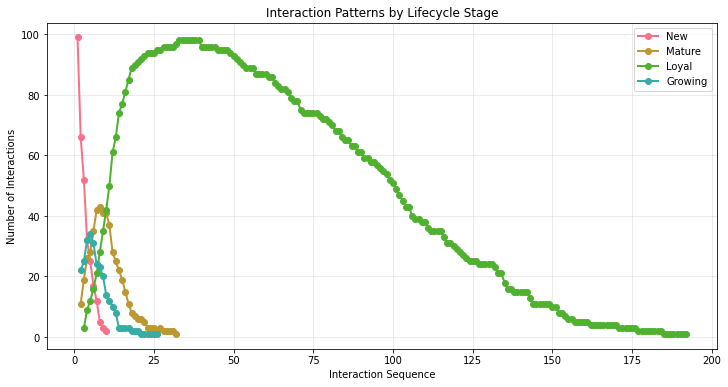

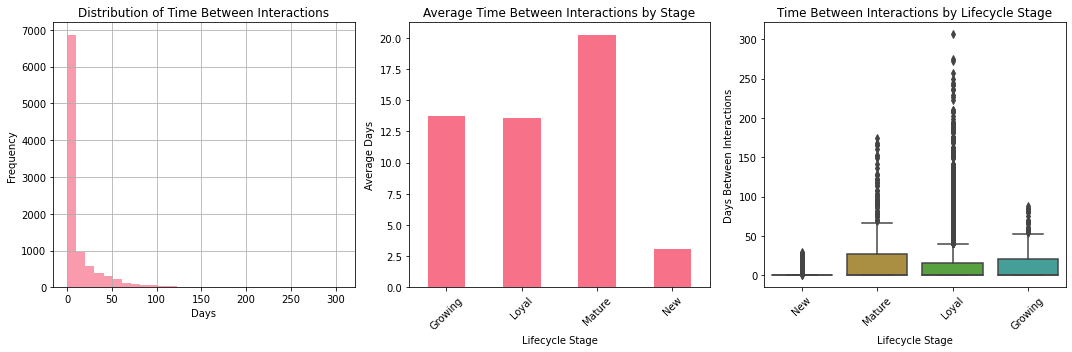

In [7]:
# Interaction frequency by lifecycle stage
interaction_by_stage = df.groupby(['lifecycle_stage', 'interaction_sequence']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
for stage in df['lifecycle_stage'].unique():
    stage_data = interaction_by_stage[interaction_by_stage['lifecycle_stage'] == stage]
    plt.plot(stage_data['interaction_sequence'], stage_data['count'], 
             marker='o', label=stage, linewidth=2)

plt.title('Interaction Patterns by Lifecycle Stage')
plt.xlabel('Interaction Sequence')
plt.ylabel('Number of Interactions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Time between interactions analysis
time_between_interactions = df[df['time_since_last_interaction'].notna()]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
time_between_interactions['time_since_last_interaction'].hist(bins=30, alpha=0.7)
plt.title('Distribution of Time Between Interactions')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
time_by_stage = time_between_interactions.groupby('lifecycle_stage')['time_since_last_interaction'].mean()
time_by_stage.plot(kind='bar')
plt.title('Average Time Between Interactions by Stage')
plt.xlabel('Lifecycle Stage')
plt.ylabel('Average Days')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=time_between_interactions, x='lifecycle_stage', y='time_since_last_interaction')
plt.title('Time Between Interactions by Lifecycle Stage')
plt.xlabel('Lifecycle Stage')
plt.ylabel('Days Between Interactions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 5. JOURNEY FLOW ANALYSIS

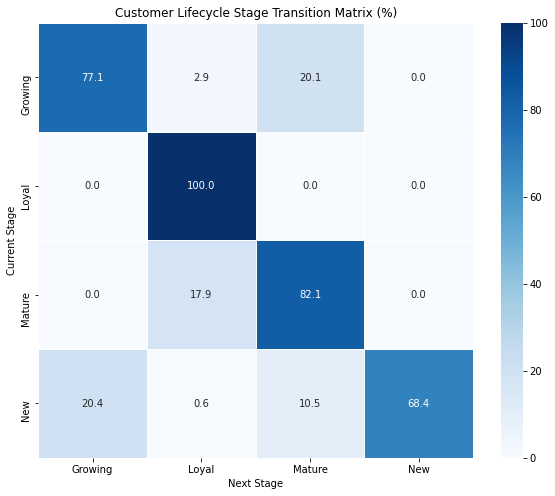

In [8]:
# Create journey flow data
def create_journey_flow(df, customer_col, max_steps=10):
    """Create journey flow analysis"""
    
    # Get journey paths for each customer
    journey_paths = df.groupby(customer_col).apply(
        lambda x: x.sort_values('interaction_sequence').head(max_steps)
    ).reset_index(drop=True)
    
    # Create step-by-step flow
    flows = []
    for customer in df[customer_col].unique():
        customer_data = df[df[customer_col] == customer].sort_values('interaction_sequence')
        
        # Get features for each step (adjust based on your actual columns)
        feature_cols = [col for col in df.columns if col not in [customer_col, date_col, 'interaction_sequence']]
        
        for i in range(len(customer_data) - 1):
            current_step = customer_data.iloc[i]
            next_step = customer_data.iloc[i + 1]
            
            flows.append({
                'customer': customer,
                'step': i + 1,
                'current_stage': current_step['lifecycle_stage'],
                'next_stage': next_step['lifecycle_stage'],
                'time_to_next': (next_step[date_col] - current_step[date_col]).days
            })
    
    return pd.DataFrame(flows)

# Create journey flow
journey_flow = create_journey_flow(df, customer_col)

# Stage transition matrix
transition_matrix = pd.crosstab(journey_flow['current_stage'], 
                               journey_flow['next_stage'], 
                               normalize='index') * 100

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='Blues', 
            square=True, linewidths=0.5)
plt.title('Customer Lifecycle Stage Transition Matrix (%)')
plt.xlabel('Next Stage')
plt.ylabel('Current Stage')
plt.show()


### 6. CUSTOMER JOURNEY COHORT ANALYSIS

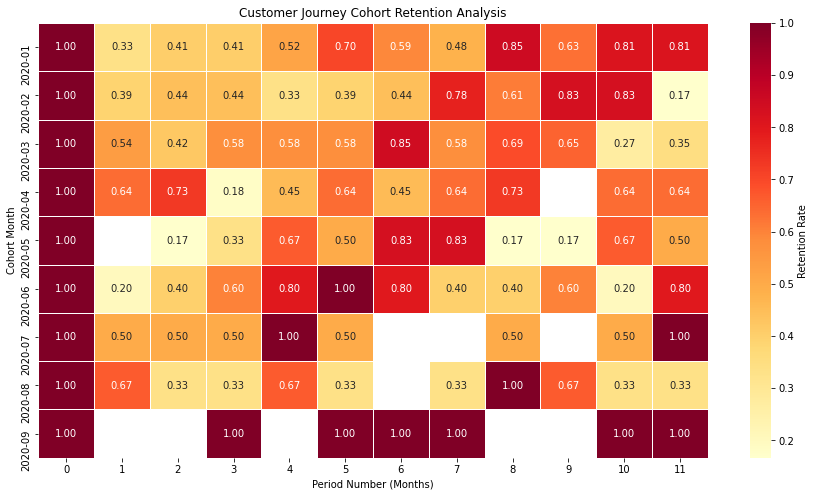

In [9]:
# Create cohort analysis based on first interaction month
def create_cohort_analysis(df, customer_col, date_col):
    """Create cohort analysis for customer journeys"""
    
    # Get first interaction date for each customer
    customer_first_interaction = df.groupby(customer_col)[date_col].min().reset_index()
    customer_first_interaction['cohort_month'] = customer_first_interaction[date_col].dt.to_period('M')
    
    # Merge back with main dataframe
    df_cohort = df.merge(customer_first_interaction[[customer_col, 'cohort_month']], on=customer_col)
    
    # Calculate period number
    df_cohort['interaction_period'] = df_cohort[date_col].dt.to_period('M')
    df_cohort['period_number'] = (df_cohort['interaction_period'] - df_cohort['cohort_month']).apply(attrgetter('n'))
    
    # Create cohort table
    cohort_table = df_cohort.groupby(['cohort_month', 'period_number'])[customer_col].nunique().reset_index()
    cohort_table = cohort_table.pivot(index='cohort_month', columns='period_number', values=customer_col)
    
    # Calculate retention rates
    cohort_sizes = df_cohort.groupby('cohort_month')[customer_col].nunique()
    cohort_retention = cohort_table.divide(cohort_sizes, axis=0)
    
    return cohort_retention

from operator import attrgetter

# Create cohort analysis
cohort_retention = create_cohort_analysis(df, customer_col, date_col)

# Plot cohort retention heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_retention.iloc[:, :12], annot=True, fmt='.2f', cmap='YlOrRd', 
            square=False, linewidths=0.5, cbar_kws={'label': 'Retention Rate'})
plt.title('Customer Journey Cohort Retention Analysis')
plt.xlabel('Period Number (Months)')
plt.ylabel('Cohort Month')
plt.show()

### 7. JOURNEY SEGMENTATION


Journey Segment Analysis:
                 customer_count  avg_interactions  avg_journey_length  \
journey_segment                                                         
Long Journey                 99            100.95             1367.52   

                 avg_interaction_frequency  
journey_segment                             
Long Journey                          0.07  


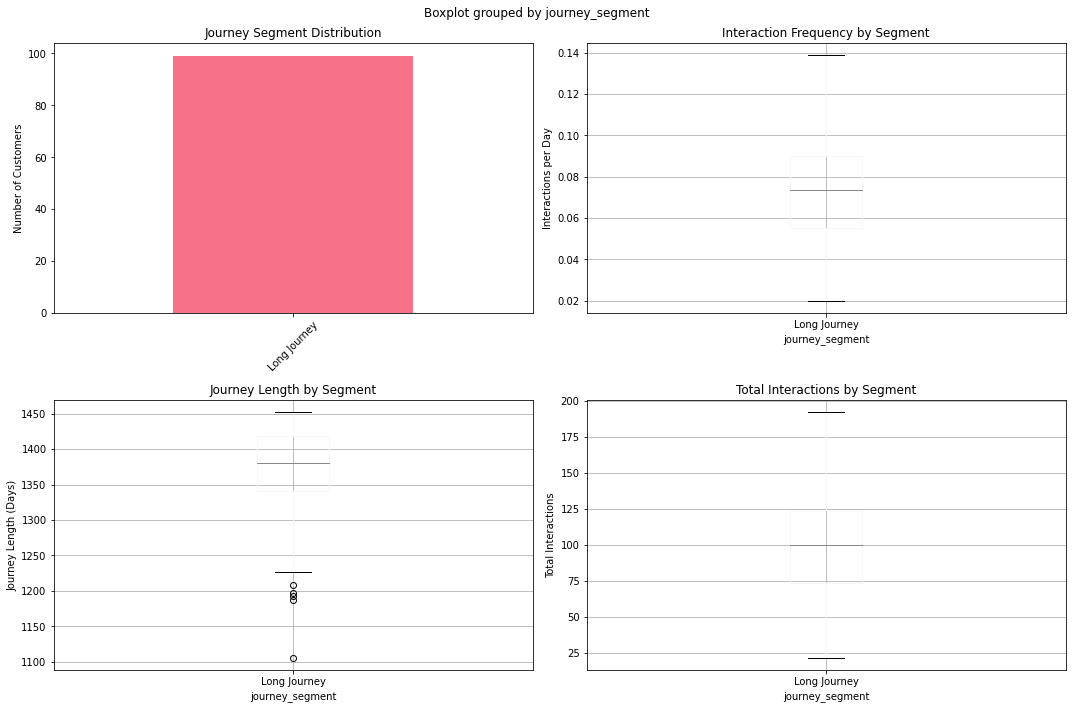

In [10]:
# Create customer journey segments
def create_journey_segments(journey_summary):
    """Segment customers based on journey characteristics"""
    
    # Calculate journey metrics
    journey_summary['interaction_frequency'] = journey_summary['total_interactions'] / (journey_summary['journey_length_days'] + 1)
    journey_summary['avg_days_between_interactions'] = journey_summary['journey_length_days'] / (journey_summary['total_interactions'] + 1)
    
    # Create segments based on interaction patterns
    def segment_customer(row):
        freq = row['interaction_frequency']
        length = row['journey_length_days']
        interactions = row['total_interactions']
        
        if freq > 0.5 and interactions > 10:
            return 'High Engagement'
        elif freq > 0.2 and interactions > 5:
            return 'Medium Engagement'
        elif length > 90:
            return 'Long Journey'
        elif interactions <= 3:
            return 'Quick Exit'
        else:
            return 'Low Engagement'
    
    journey_summary['journey_segment'] = journey_summary.apply(segment_customer, axis=1)
    
    return journey_summary

# Apply journey segmentation
journey_segments = create_journey_segments(journey_summary.copy())

# Journey segment analysis
segment_analysis = journey_segments.groupby('journey_segment').agg({
    'total_interactions': ['count', 'mean'],
    'journey_length_days': 'mean',
    'interaction_frequency': 'mean'
}).round(2)

segment_analysis.columns = ['customer_count', 'avg_interactions', 'avg_journey_length', 'avg_interaction_frequency']

print("\nJourney Segment Analysis:")
print(segment_analysis)

# Visualize journey segments
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Segment distribution
journey_segments['journey_segment'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Journey Segment Distribution')
axes[0,0].set_ylabel('Number of Customers')
axes[0,0].tick_params(axis='x', rotation=45)

# Interaction frequency by segment
journey_segments.boxplot(column='interaction_frequency', by='journey_segment', ax=axes[0,1])
axes[0,1].set_title('Interaction Frequency by Segment')
axes[0,1].set_ylabel('Interactions per Day')

# Journey length by segment
journey_segments.boxplot(column='journey_length_days', by='journey_segment', ax=axes[1,0])
axes[1,0].set_title('Journey Length by Segment')
axes[1,0].set_ylabel('Journey Length (Days)')

# Total interactions by segment
journey_segments.boxplot(column='total_interactions', by='journey_segment', ax=axes[1,1])
axes[1,1].set_title('Total Interactions by Segment')
axes[1,1].set_ylabel('Total Interactions')

plt.tight_layout()
plt.show()

### 8. INTERACTIVE JOURNEY VISUALIZATION

In [12]:
# Create interactive journey timeline
def create_interactive_timeline(df, customer_col, date_col, sample_customers=10):
    """Create interactive timeline for customer journeys"""
    
    # Sample customers for visualization
    sample_customers_list = df[customer_col].unique()[:sample_customers]
    sample_data = df[df[customer_col].isin(sample_customers_list)]
    
    # Create timeline plot
    fig = px.scatter(sample_data, 
                     x=date_col, 
                     y=customer_col,
                     color='lifecycle_stage',
                     size='interaction_sequence',
                     hover_data=['customer_journey_day', 'interaction_sequence'],
                     title='Customer Journey Timeline',
                     labels={'interaction_sequence': 'Interaction #'})
    
    fig.update_layout(height=600, showlegend=True)
    return fig

# Create and display interactive timeline
timeline_fig = create_interactive_timeline(df, customer_col, date_col)
timeline_fig.show()

### 9. JOURNEY INSIGHTS AND RECOMMENDATIONS

In [13]:
print("\n" + "="*80)
print("CUSTOMER JOURNEY MAPPING INSIGHTS")
print("="*80)

# Key insights
total_customers = df[customer_col].nunique()
avg_journey_length = journey_summary['journey_length_days'].mean()
avg_interactions = journey_summary['total_interactions'].mean()
most_common_stage = df['lifecycle_stage'].value_counts().index[0]
avg_time_between = df['time_since_last_interaction'].mean()

print(f"\n📊 JOURNEY OVERVIEW:")
print(f"   • Total Customers Analyzed: {total_customers:,}")
print(f"   • Average Journey Length: {avg_journey_length:.1f} days")
print(f"   • Average Interactions per Customer: {avg_interactions:.1f}")
print(f"   • Most Common Lifecycle Stage: {most_common_stage}")
print(f"   • Average Time Between Interactions: {avg_time_between:.1f} days")

print(f"\n🎯 SEGMENT INSIGHTS:")
for segment in journey_segments['journey_segment'].unique():
    segment_data = journey_segments[journey_segments['journey_segment'] == segment]
    count = len(segment_data)
    pct = (count / total_customers) * 100
    print(f"   • {segment}: {count} customers ({pct:.1f}%)")

print(f"\n📈 TRANSITION INSIGHTS:")
print("   • Most common stage transitions:")
transition_counts = pd.crosstab(journey_flow['current_stage'], journey_flow['next_stage'])
for i in range(min(3, len(transition_counts))):
    max_idx = transition_counts.values.argmax()
    row, col = np.unravel_index(max_idx, transition_counts.shape)
    from_stage = transition_counts.index[row]
    to_stage = transition_counts.columns[col]
    count = transition_counts.iloc[row, col]
    print(f"     - {from_stage} → {to_stage}: {count} transitions")
    transition_counts.iloc[row, col] = 0

print(f"\n💡 RECOMMENDATIONS:")
print("   • Focus on converting 'New' customers to 'Growing' stage")
print("   • Develop retention strategies for 'Quick Exit' segment")
print("   • Optimize engagement frequency for 'Low Engagement' customers")
print("   • Leverage 'High Engagement' customers for referrals")
print("   • Create targeted campaigns based on lifecycle stages")

print("\n" + "="*80)
print("Analysis Complete! Use these insights to optimize customer journeys.")
print("="*80)


CUSTOMER JOURNEY MAPPING INSIGHTS

📊 JOURNEY OVERVIEW:
   • Total Customers Analyzed: 99
   • Average Journey Length: 1367.5 days
   • Average Interactions per Customer: 100.9
   • Most Common Lifecycle Stage: Loyal
   • Average Time Between Interactions: 13.7 days

🎯 SEGMENT INSIGHTS:
   • Long Journey: 99 customers (100.0%)

📈 TRANSITION INSIGHTS:
   • Most common stage transitions:
     - Loyal → Loyal: 8805 transitions
     - Mature → Mature: 409 transitions
     - Growing → Growing: 215 transitions

💡 RECOMMENDATIONS:
   • Focus on converting 'New' customers to 'Growing' stage
   • Develop retention strategies for 'Quick Exit' segment
   • Optimize engagement frequency for 'Low Engagement' customers
   • Leverage 'High Engagement' customers for referrals
   • Create targeted campaigns based on lifecycle stages

Analysis Complete! Use these insights to optimize customer journeys.
